In [16]:
from vampyre_dataset import load_vampyre_data

In [45]:
import torch

In [41]:
from scipy.interpolate import interp1d

########
#
# compute
#
########
def upsample(df_model, x_col_model, df_target, x_col_target):
    
    df_out = df_target[[x_col_target]].copy()
    
    for col in df_model.drop(x_col_model, axis=1).columns:
        f = interp1d(df_model[x_col_model], 
                                 df_model[col])
        
        df_out[col] = df_out[x_col_target].transform(f)
        
    return df_out

dd = load_vampyre_data()

df_upsampled = upsample(dd['track_sf1'], 'Distance', dd['vampyre_sf1'], 'Distance')

In [82]:
dd['vampyre_sf1'].columns

Index(['Distance', 'Accel WS1 Y', 'Accel WS2 Y', 'Accel WS1 Z', 'Accel WS2 Z',
       'Accel WS1 Roll', 'Accel WS2 Roll', 'Accel WS1 Yaw', 'Accel WS2 Yaw',
       'Accel_Pitch CarbodyCentre', 'Accel_Vert CarbodyCentre',
       'Accel_Long CarbodyCentre', 'Accel_Lat CarbodyCentre',
       'Accel_Vert Carbody above WS1', 'Accel_Vert Carbody above WS2',
       'Accel_Lat Carbody above WS1', 'Accel_Lat Carbody above WS2',
       'dQ/Q Left wheel WS1', 'dQ/Q Right wheel WS1', 'dQ/Q Left wheel WS2',
       'dQ/Q Right wheel WS2', 'Y/Q Left wheel WS1', 'Y/Q Right wheel WS1',
       'Y/Q Left wheel WS2', 'Y/Q Right wheel WS2', 'Left Wheel Lift WS1',
       'Right Wheel Lift WS1', 'Left Wheel Lift WS2', 'Right Wheel Lift WS2'],
      dtype='object')

In [110]:
from torch.utils import data as tdata
import numpy as np

num_elem = 5000

to_predict = ['Y/Q Left wheel WS1', 
               'Y/Q Right wheel WS1',
               'Y/Q Left wheel WS2', 
               'Y/Q Right wheel WS2']

x = torch.from_numpy(df_upsampled.drop('Distance', axis=1).iloc[:num_elem].values)
y = torch.from_numpy(dd['vampyre_sf1'].iloc[:num_elem].loc[:, to_predict].values)

mydset = tdata.TensorDataset(x, y)

# https://am207.github.io/2018spring/wiki/ValidationSplits.html

# define our indices -- our dataset has 9 elements and we want a 8:4 split
num_train = len(mydset)
indices = list(range(num_train))
split = 1000

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## define our samplers -- we use a SubsetRandomSampler because it will return
## a random subset of the split defined by the given indices without replac
train_sampler = tdata.SubsetRandomSampler(train_idx)
validation_sampler = tdata.SubsetRandomSampler(validation_idx)

train_loader = tdata.DataLoader(mydset, 
                batch_size=100, sampler=train_sampler)

validation_loader = tdata.DataLoader(mydset, 
                batch_size=100, sampler=validation_sampler)

In [86]:
#for epoch in range(2):   
#    for batch_index, (inputs, labels) in enumerate(train_loader):
#        print(epoch, batch_index, labels)

size_list = [x.size() for x in train_loader.dataset.tensors]

D_in = size_list[0][1]
H = size_list[0][1]
D_out = size_list[1][1]

print(D_in, D_out)

5 4


In [93]:
# set hyper parameters
learning_rate = 1e-4

# model
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
model = model.double()

# loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

# optimizer

# learning
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_loss = []
test_loss = []

for epoch in range(500):   
    
    epoch_train_loss = []
    for batch_index, (x, y) in enumerate(train_loader):

        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        
        epoch_train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
            # train callback
            train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
            
            # test callback
            # test values on test samples
            test_l = []
            for test_x, test_y in validation_loader:
                test_l.append(loss_fn(model(test_x), test_y).item())
            test_loss.append(sum(test_l) / len(test_l))
            
            # print
            #print(batch_index, loss.item())

    

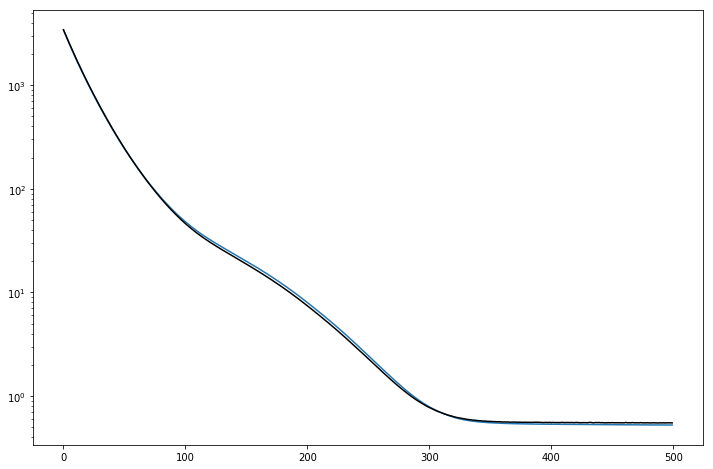

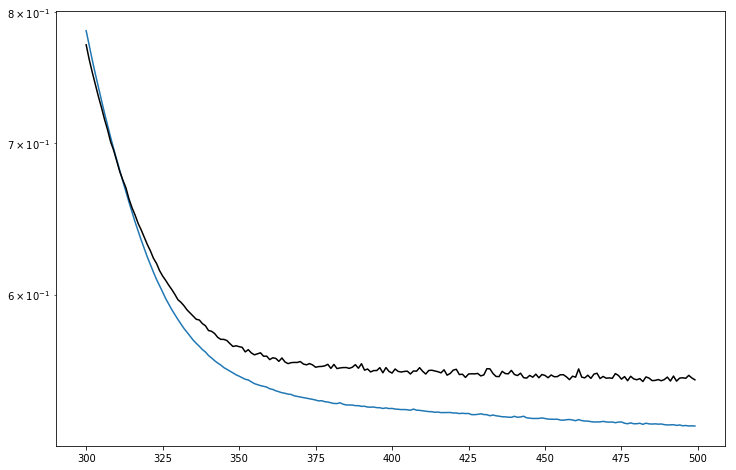

In [96]:
import pandas as pd

df_loss = pd.DataFrame({'train':train_loss, 'test':test_loss})


plt.figure(figsize=[12, 8])
plt.semilogy('train', data = df_loss)
plt.semilogy('test', data = df_loss, color='k')

plt.figure(figsize=[12, 8])
plt.semilogy('train', data = df_loss[300:])
plt.semilogy('test', data = df_loss[300:], color='k')

In [108]:
v2 = tdata.DataLoader(mydset, 
                batch_size=1000, sampler=validation_sampler)

test_x_set, test_y_set = [x for x in v2][0]

with torch.no_grad():
    test_y_pred = model(test_x_set)
    error = (test_y_pred - test_y_set).numpy()    
    

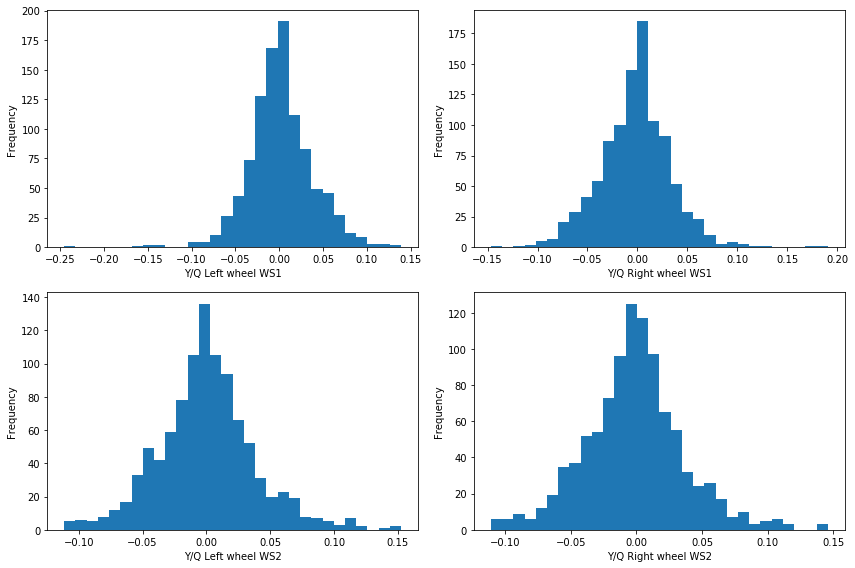

In [117]:
df_error = pd.DataFrame(error, columns=to_predict)

plt.figure(figsize=[12, 8])
for i, col in enumerate(to_predict):
    ax = plt.subplot(2, 2, i + 1)
    df_error[col].plot(kind='hist', ax=ax, bins=30)
    plt.xlabel(col)

plt.tight_layout()

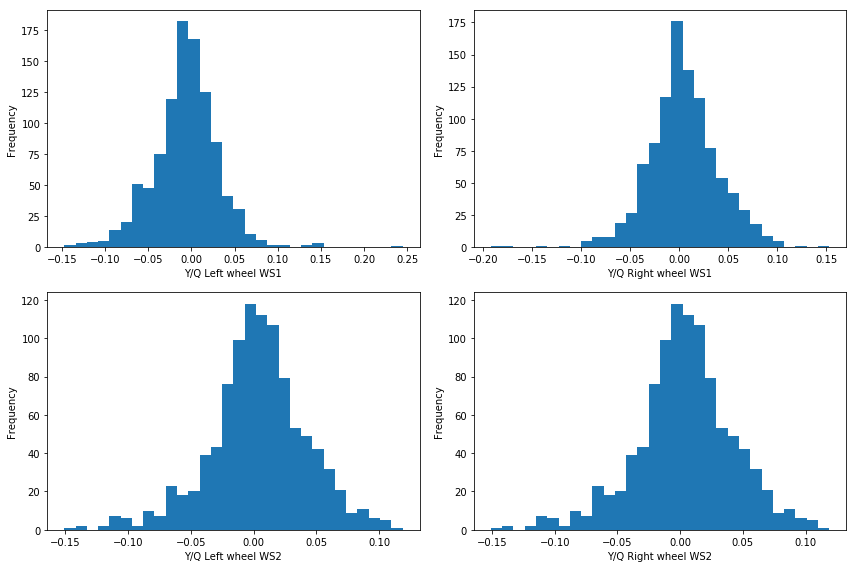

In [120]:
df = pd.DataFrame(test_y_set.numpy(), columns=to_predict)

plt.figure(figsize=[12, 8])
for i, col in enumerate(to_predict):
    ax = plt.subplot(2, 2, i + 1)
    df[col].plot(kind='hist', ax=ax, bins=30)
    plt.xlabel(col)

plt.tight_layout()